In [1]:
import osmnx as ox
import networkx as nx
from shapely.geometry import MultiLineString, Point
import pandas as pd
import geopandas as gpd
import contextily as ctx
import pyproj
from shapely.ops import transform

In [2]:
G = ox.io.load_graphml("data/LACounty.graphml")

In [3]:
dfLoc = pd.read_csv("data/Location.csv", float_precision="%.5f")
dfLoc = dfLoc[((dfLoc['loctype'] == 2) | (dfLoc['loctype'] == 1)) & (dfLoc['cntyfips'] == 37)]
def getHouseper(r):
    return "{}_{}".format(r['houseid'], r['personid'])

dfLoc['houseper'] = dfLoc.apply(lambda row: getHouseper(row), axis = 1)

In [4]:
homes = dfLoc[dfLoc['locname'] == "HOME"]

In [5]:
dfPer = pd.read_csv("data/Person.csv", low_memory=False)
dfPer['houseper'] = dfPer.apply(lambda row: getHouseper(row), axis=1)
dfPer = dfPer[['houseper', 'r_race', 'r_hisp', 'r_age', 'educ']]

In [6]:
df = pd.merge(dfLoc, dfPer, on='houseper', how='inner')

In [15]:
hisp = df[df['r_hisp'] == 1]
white = df[(df['r_hisp'] == 2) & (df['r_race'] == 1)]
black = df[(df['r_hisp'] == 2) & (df['r_race'] == 2)]
asian = df[(df['r_hisp'] == 2) & (df['r_race'] == 3)]
other = df[(df['r_hisp'] == 2) & ((df['r_race'] == 97) | (df['r_race'] == 4) | (df['r_race'] == 5))]

In [20]:
hisp_works = hisp[hisp['loctype'] == 2]
white_works = white[white['loctype'] == 2]
black_works = black[black['loctype'] == 2]
asian_works = asian[asian['loctype'] == 2]
other_works = other[other['loctype'] == 2]

In [32]:
def getTrips(d):
    starts = []
    ends = []
    for index, row in d.iterrows():
        if homes[homes['houseid'] == row['houseid']].shape[0] < 1:
            continue
        end = (row['latitude'], row['longitude'])
        start = (homes[homes['houseid'] == row['houseid']].iloc[0]['latitude'], homes[homes['houseid'] == row['houseid']].iloc[0]['longitude'])
        starts.append(start)
        ends.append(end)
    trips = pd.DataFrame({'home': starts, 'work': ends})
    return trips

def getPaths(d):
    geom = []
    for index, row in d.iterrows():
        orig = ox.get_nearest_node(G, row['home'])
        dest = ox.get_nearest_node(G, row['work'])
        route = nx.shortest_path(G, orig, dest)
        route_pairwise = zip(route[:-1], route[1:])
        edges = ox.graph_to_gdfs(G, nodes=False).set_index(['u', 'v']).sort_index()
        lines = [edges.loc[uv, 'geometry'].iloc[0] for uv in route_pairwise]
        geom.append(MultiLineString(lines))
    return geom

def toShapefile(d, r):
    t = {'geometry': d}
    gdf = gpd.GeoDataFrame(t, crs="EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")
    ax = gdf.plot(figsize=(18,18),edgecolor='green', alpha=0.2)
    # ctx.providers.Stamen.TonerLite
    # Maps here: https://github.com/darribas/contextily
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    gdf.to_file("data/{}.shp".format(r))

In [38]:
print(black_works.shape[0])

123


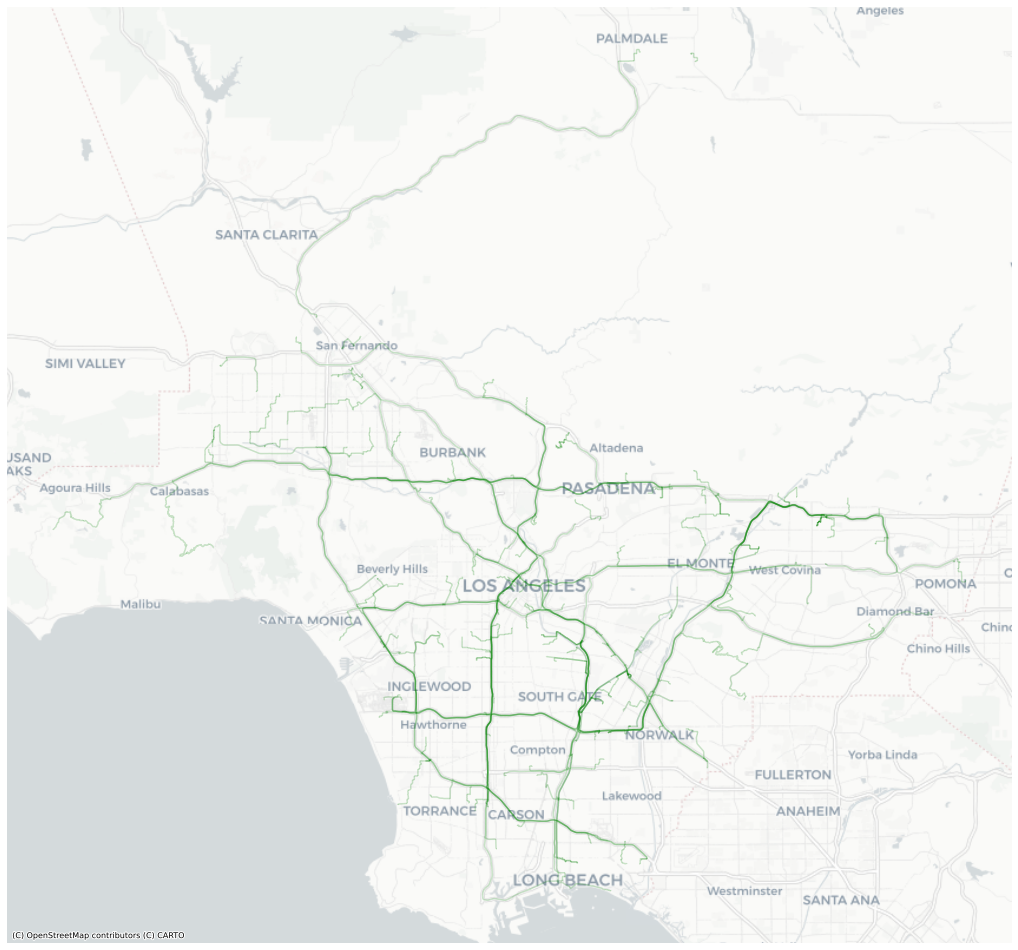

In [39]:
toShapefile(getPaths(getTrips(hisp_works.head(120))), "hispanic120")

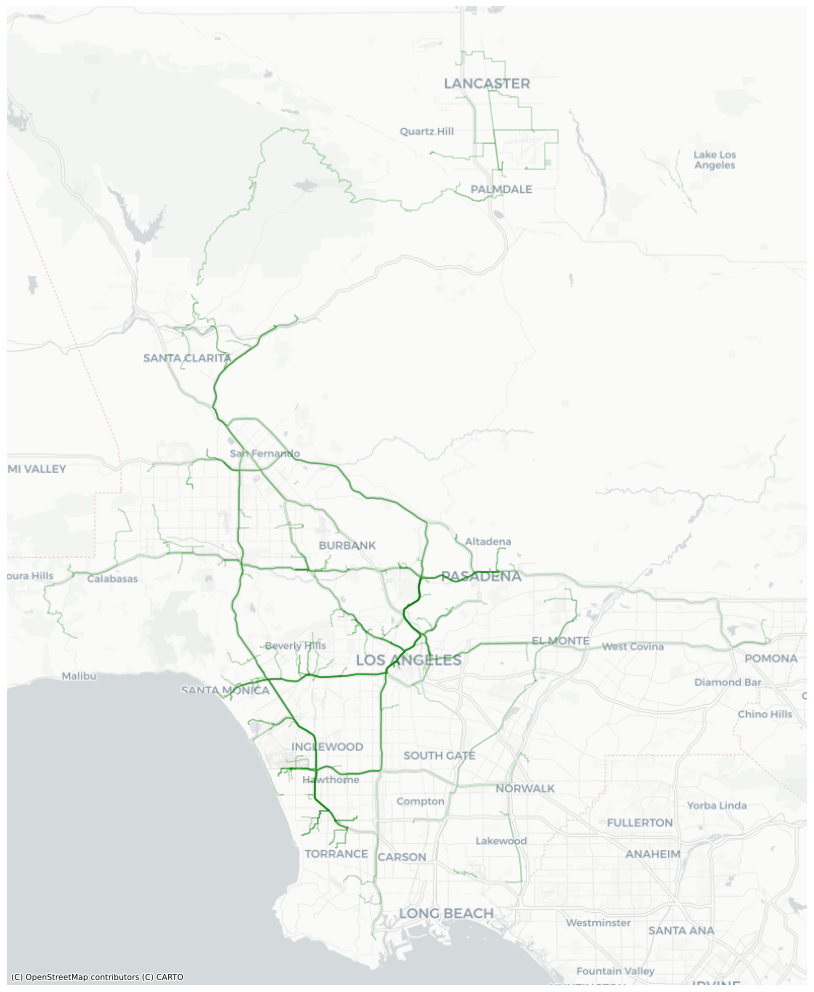

In [40]:
toShapefile(getPaths(getTrips(white_works.head(120))), "white120")

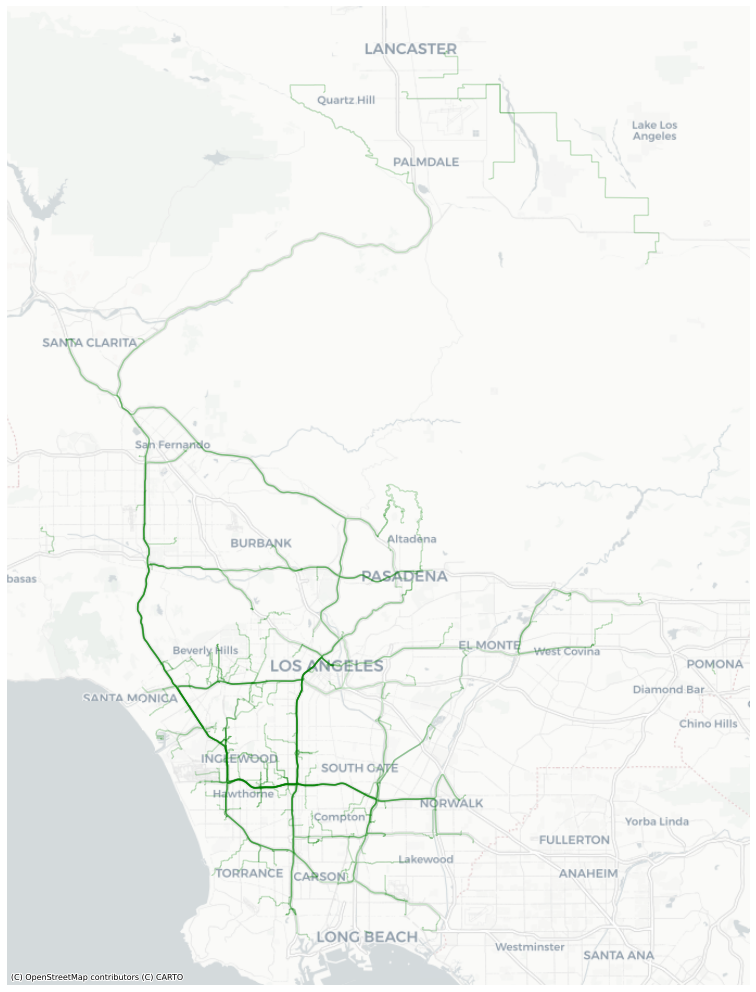

In [41]:
toShapefile(getPaths(getTrips(black_works.head(120))), "black120")

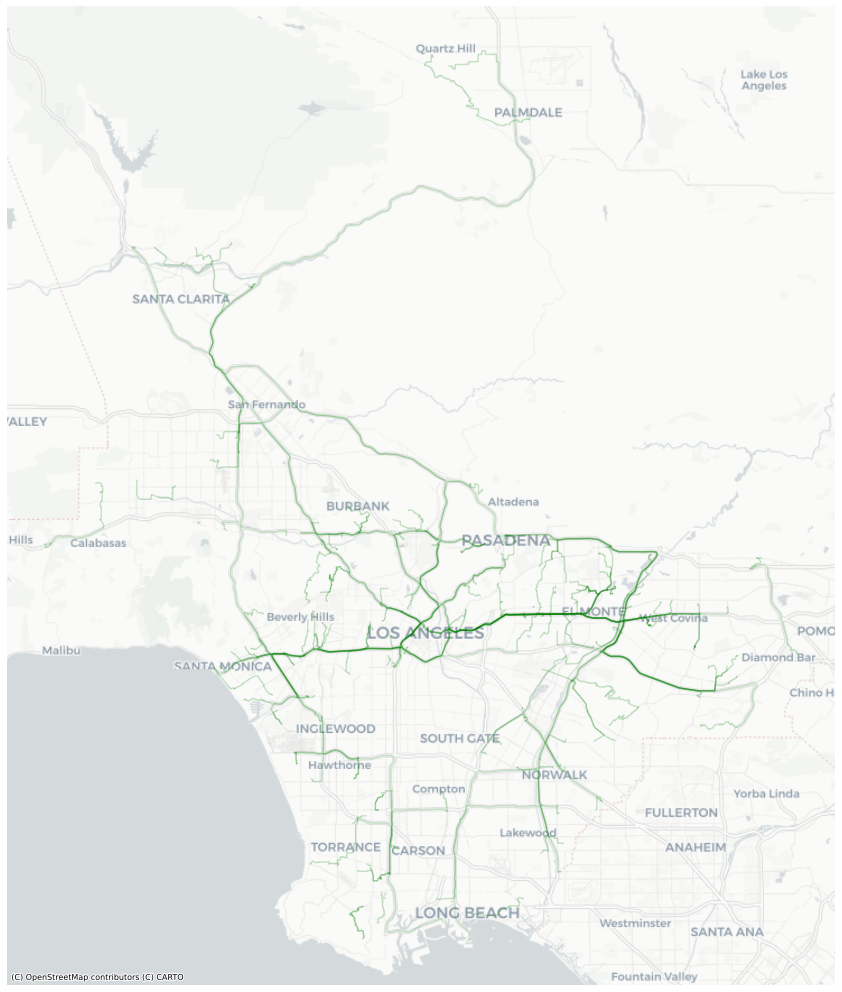

In [44]:
toShapefile(getPaths(getTrips(asian_works.tail(120))), "asian120")

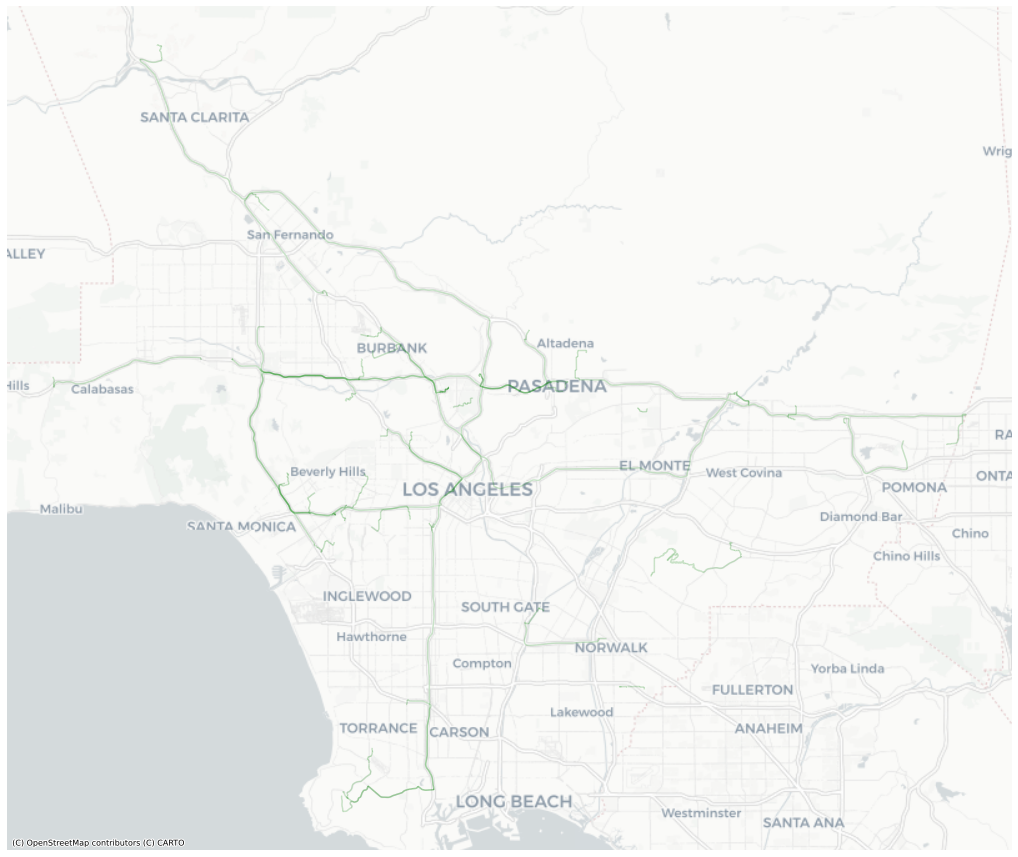

In [43]:
toShapefile(getPaths(getTrips(other_works)), "other")